# MTA Elevator and Escalator Status

The [Metropolitan Transportation Authority (MTA) Subway Elev & Esc](https://mta-equip-map.herokuapp.com/) brings users real time information with the number of elevators and escalators throughout the five boroughs.

## Introduction

This quick and easy application allows users to select subway stations by borough which returns the number of escalators and color coded elevator service status at the station. The collapsible menu expands to display the elevator’s serving area, alternative route, bus connections and if out of service, provides the estimated return to service date and time. These features removes the stress of riders knowing the equipment status before arriving to the station. It also provides a general real time outage status every 5 minutes of all elevators and escalators throughout the city. 

The goal of this project is to provide reliable access information of subway elevators and escalators and improve the way riders access that information.

As we begin to welcome back ridership within the transit system, we must address accessibility concerns regarding capital projects and communicate clearly with riders adjustments needed to complete their journey.

The application data is collected from MTA’s open dataset and developed using HTML/CSS/JavaScript and Python technology.

In [1]:
#----------------------------------------------------------------------------#
# Imports
#----------------------------------------------------------------------------#
import requests, json, os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## Projected Population 2010-2040 - Total By Age Groups

- [Open Data NYC](https://data.cityofnewyork.us/City-Government/Projected-Population-2010-2040-Total-By-Age-Groups/97pn-acdf)

```
Borough, Age, 2010, 2015, 2020, 2025, 2030, 2035, 2040
```

In [2]:
population_csv = 'https://data.cityofnewyork.us/resource/97pn-acdf.csv'
population_data = pd.read_csv(population_csv, header=0)
population_data

,borough,age,_1,_2,_3,_4,_5,_6,_7
0,NYC Total,0-4,521990,535209,545778,547336,542426,540523,546426
1,NYC Total,15-19,539844,505783,492532,519298,535024,546062,546750
2,NYC Total,20-24,647483,646075,606203,591683,625253,643728,657403
3,NYC Total,25-29,736105,770396,763956,715824,698195,740437,762757
4,NYC Total,30-34,667657,707726,743916,740268,693684,675497,715486
...,...,...,...,...,...,...,...,...,...
109,Staten Island,10-14,30797,30703,30307,30001,30541,31074,30932
110,Queens,10-14,124320,123672,129351,130384,132038,133473,133813
111,Manhattan,10-14,58229,55455,60331,62902,66322,66700,63630
112,Brooklyn,10-14,159404,155314,166761,174242,175992,173419,171265


In [3]:
population_data.columns

Index(['borough', 'age', '_1', '_2', '_3', '_4', '_5', '_6', '_7'], dtype='object')

In [4]:
population_data = population_data.rename({'borough':'Borough', 'age':'Age', '_1':'2010','_2':'2015','_3':'2020','_4':'2025','_5':'2030','_6':'2035','_7':'2040'}, axis='columns')
population_data

,Borough,Age,2010,2015,2020,2025,2030,2035,2040
0,NYC Total,0-4,521990,535209,545778,547336,542426,540523,546426
1,NYC Total,15-19,539844,505783,492532,519298,535024,546062,546750
2,NYC Total,20-24,647483,646075,606203,591683,625253,643728,657403
3,NYC Total,25-29,736105,770396,763956,715824,698195,740437,762757
4,NYC Total,30-34,667657,707726,743916,740268,693684,675497,715486
...,...,...,...,...,...,...,...,...,...
109,Staten Island,10-14,30797,30703,30307,30001,30541,31074,30932
110,Queens,10-14,124320,123672,129351,130384,132038,133473,133813
111,Manhattan,10-14,58229,55455,60331,62902,66322,66700,63630
112,Brooklyn,10-14,159404,155314,166761,174242,175992,173419,171265


In [5]:
population_data[population_data["Borough"] == 'NYC Total'].sort_values(by=['Age'])

,Borough,Age,2010,2015,2020,2025,2030,2035,2040
0,NYC Total,0-4,521990,535209,545778,547336,542426,540523,546426
103,NYC Total,10-14,471909,457567,482453,497610,508958,509963,504650
1,NYC Total,15-19,539844,505783,492532,519298,535024,546062,546750
2,NYC Total,20-24,647483,646075,606203,591683,625253,643728,657403
3,NYC Total,25-29,736105,770396,763956,715824,698195,740437,762757
4,NYC Total,30-34,667657,707726,743916,740268,693684,675497,715486
5,NYC Total,35-39,592299,611239,649594,684249,682964,639237,621899
6,NYC Total,40-44,571825,550097,569628,606185,638148,637517,596493
7,NYC Total,45-49,570273,535998,517668,537516,571723,600792,600514
102,NYC Total,5-9,477039,501640,516006,527690,529397,524170,522152


<AxesSubplot:ylabel='Age'>

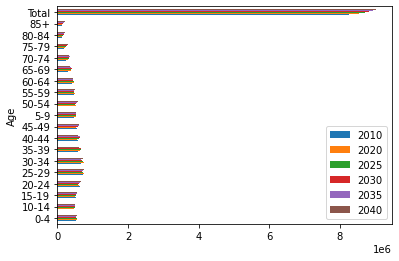

In [6]:
pf_NYC_Total = population_data[population_data["Borough"] == 'NYC Total'].sort_values(by=['Age'])
pf_NYC_Total.plot.barh(x='Age', y=['2010', '2020', '2025', '2030', '2035', '2040'])

<AxesSubplot:ylabel='Age'>

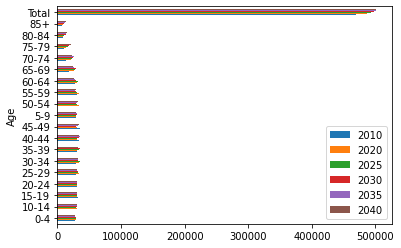

In [42]:
pf_Manhattan = population_data[population_data["Borough"] == 'Staten Island'].sort_values(by=['Age'])
pf_Manhattan.plot.barh(x='Age', y=['2010', '2020', '2025', '2030', '2035', '2040'])

## Get MTA API

- Get API key from https://api.mta.info/#/signup

## MTA Resources

- [Data Feeds](http://web.mta.info/developers/developer-data-terms.html#data)
- [Realtime Data Feeds](https://api.mta.info/#/landing)
- Colors
    - [HTML](http://web.mta.info/developers/resources/line_colors.htm)
    - [CSV](http://web.mta.info/developers/data/colors.csv)

In [8]:
# ----------------------------------------------------------------------------#
# Use API key to access MTA Data
#----------------------------------------------------------------------------#

from dotenv import load_dotenv, find_dotenv # imports module for dotenv
load_dotenv(find_dotenv()) # loads .env from root directory

# The root directory requires a .env file with API_KEY assigned/defined within
# and dotenv installed from pypi. Get API key from http://datamine.mta.info/user
# api_key = os.environ['API_KEY']

True

In [9]:
# Elevators feed
from urllib.request import Request, urlopen
from xml.etree.ElementTree import parse
import xml.etree.ElementTree as ET

In [10]:
# MTA NYC Transit Station Locations – Updated February 17, 2021
station_location = 'https://atisdata.s3.amazonaws.com/Station/Stations.csv'
station_location_data = pd.read_csv(station_location, header=0)

In [11]:
df = pd.DataFrame(station_location_data)
df

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,ADA,ADA Notes
0,1,1,R01,BMT,Astoria,Astoria-Ditmars Blvd,Q,N W,Elevated,40.775036,-73.912034,NaN,Manhattan,0,NaN
1,2,2,R03,BMT,Astoria,Astoria Blvd,Q,N W,Elevated,40.770258,-73.917843,Ditmars Blvd,Manhattan,1,NaN
2,3,3,R04,BMT,Astoria,30 Av,Q,N W,Elevated,40.766779,-73.921479,Astoria - Ditmars Blvd,Manhattan,0,NaN
3,4,4,R05,BMT,Astoria,Broadway,Q,N W,Elevated,40.761820,-73.925508,Astoria - Ditmars Blvd,Manhattan,0,NaN
4,5,5,R06,BMT,Astoria,36 Av,Q,N W,Elevated,40.756804,-73.929575,Astoria - Ditmars Blvd,Manhattan,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,517,517,S15,SIR,Staten Island,Prince's Bay,SI,SIR,Open Cut,40.525507,-74.200064,St George,Tottenville,0,NaN
492,518,518,S14,SIR,Staten Island,Pleasant Plains,SI,SIR,Embankment,40.522410,-74.217847,St George,Tottenville,0,NaN
493,519,519,S13,SIR,Staten Island,Richmond Valley,SI,SIR,Open Cut,40.519631,-74.229141,St George,Tottenville,0,NaN
494,522,522,S09,SIR,Staten Island,Tottenville,SI,SIR,At Grade,40.512764,-74.251961,St George,NaN,1,NaN


In [12]:
df.dtypes

Station ID                 int64
Complex ID                 int64
GTFS Stop ID              object
Division                  object
Line                      object
Stop Name                 object
Borough                   object
Daytime Routes            object
Structure                 object
GTFS Latitude            float64
GTFS Longitude           float64
North Direction Label     object
South Direction Label     object
ADA                        int64
ADA Notes                 object
dtype: object

In [13]:
df['Borough Name'] = df['Borough'].replace(['Q', 'M', 'Bk', 'Bx', 'SI'],['Queens', 'Manhattan', 'Brooklyn', 'Bronx', 'Staten Island'])

In [14]:
df['Borough Name']

0             Queens
1             Queens
2             Queens
3             Queens
4             Queens
           ...      
491    Staten Island
492    Staten Island
493    Staten Island
494    Staten Island
495    Staten Island
Name: Borough Name, Length: 496, dtype: object

In [15]:
boros = df["Borough Name"].unique()
boros

array(['Queens', 'Manhattan', 'Brooklyn', 'Bronx', 'Staten Island'],
      dtype=object)

In [16]:
len_of_row = len(df.index)
len_of_row

496

In [17]:
# Qeens Stations
queen_station = df[df["Borough Name"] == 'Queens'].copy()
queen_station

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,ADA,ADA Notes,Borough Name
0,1,1,R01,BMT,Astoria,Astoria-Ditmars Blvd,Q,N W,Elevated,40.775036,-73.912034,NaN,Manhattan,0,NaN,Queens
1,2,2,R03,BMT,Astoria,Astoria Blvd,Q,N W,Elevated,40.770258,-73.917843,Ditmars Blvd,Manhattan,1,NaN,Queens
2,3,3,R04,BMT,Astoria,30 Av,Q,N W,Elevated,40.766779,-73.921479,Astoria - Ditmars Blvd,Manhattan,0,NaN,Queens
3,4,4,R05,BMT,Astoria,Broadway,Q,N W,Elevated,40.761820,-73.925508,Astoria - Ditmars Blvd,Manhattan,0,NaN,Queens
4,5,5,R06,BMT,Astoria,36 Av,Q,N W,Elevated,40.756804,-73.929575,Astoria - Ditmars Blvd,Manhattan,0,NaN,Queens
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,461,461,718,IRT,Flushing,Queensboro Plaza,Q,7,Elevated,40.750582,-73.940202,Astoria - Flushing,Manhattan,0,NaN,Queens
462,461,461,R09,BMT,Astoria,Queensboro Plaza,Q,N W,Elevated,40.750582,-73.940202,Astoria - Flushing,Manhattan,0,NaN,Queens
463,462,606,719,IRT,Flushing,Court Sq,Q,7,Elevated,40.747023,-73.945264,Flushing,Manhattan,1,NaN,Queens
464,463,463,720,IRT,Flushing,Hunters Point Av,Q,7,Subway,40.742216,-73.948916,Flushing,Manhattan,0,NaN,Queens


In [18]:
num_of_queen_station = len(queen_station.index)
num_of_queen_station

83

In [19]:
queen_station['Line'].unique()

array(['Astoria', 'Jamaica', 'Myrtle Av', 'Canarsie', 'Liberty Av',
       'Rockaway', '63rd St', 'Queens Blvd', 'Queens - Archer',
       'Crosstown', 'Flushing'], dtype=object)

In [20]:
# Brooklyn Stations
brooklyn_station = df[df["Borough Name"] == 'Brooklyn'].copy()
brooklyn_station

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,ADA,ADA Notes,Borough Name
23,24,620,R28,BMT,Broadway,Court St,Bk,R,Subway,40.694100,-73.991777,Manhattan,Bay Ridge - 95 St,0,NaN,Brooklyn
24,25,636,R29,BMT,Broadway,Jay St-MetroTech,Bk,R,Subway,40.692180,-73.985942,Manhattan,Bay Ridge - 95 St,1,NaN,Brooklyn
25,26,26,R30,BMT,Broadway - Brighton,DeKalb Av,Bk,B Q R,Subway,40.690635,-73.981824,Manhattan,Coney Island - Bay Ridge,1,NaN,Brooklyn
26,27,617,R31,BMT,4th Av,Atlantic Av-Barclays Ctr,Bk,D N R,Subway,40.683666,-73.978810,Manhattan,Coney Island - Bay Ridge,1,NaN,Brooklyn
27,28,28,R32,BMT,4th Av,Union St,Bk,R,Subway,40.677316,-73.983110,Manhattan,Bay Ridge - 95 St,0,NaN,Brooklyn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,356,356,244,IRT,Nostrand,Church Av,Bk,2 5,Subway,40.650843,-73.949575,Manhattan,Flatbush,1,NaN,Brooklyn
357,357,357,245,IRT,Nostrand,Beverly Rd,Bk,2 5,Subway,40.645098,-73.948959,Manhattan,Flatbush,0,NaN,Brooklyn
358,358,358,246,IRT,Nostrand,Newkirk Av,Bk,2 5,Subway,40.639967,-73.948411,Manhattan,Flatbush,0,NaN,Brooklyn
359,359,359,247,IRT,Nostrand,Flatbush Av-Brooklyn College,Bk,2 5,Subway,40.632836,-73.947642,Manhattan,NaN,1,NaN,Brooklyn


In [21]:
num_of_brooklyn_station = len(brooklyn_station.index)
num_of_brooklyn_station

169

In [22]:
# Manhattan Stations
manhattan_station = df[df["Borough Name"] == 'Manhattan'].copy()
manhattan_station

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,ADA,ADA Notes,Borough Name
6,7,613,R11,BMT,Astoria,Lexington Av/59 St,M,N W R,Subway,40.762660,-73.967258,Queens,Downtown & Brooklyn,0,NaN,Manhattan
7,8,8,R13,BMT,Astoria,5 Av/59 St,M,N W R,Subway,40.764811,-73.973347,Queens,Downtown & Brooklyn,0,NaN,Manhattan
8,9,9,R14,BMT,Broadway - Brighton,57 St-7 Av,M,N Q R W,Subway,40.764664,-73.980658,Uptown & Queens,Downtown & Brooklyn,0,NaN,Manhattan
9,10,10,R15,BMT,Broadway - Brighton,49 St,M,N R W,Subway,40.759901,-73.984139,Uptown & Queens,Downtown & Brooklyn,2,Uptown only,Manhattan
10,11,611,R16,BMT,Broadway - Brighton,Times Sq-42 St,M,N Q R W,Subway,40.754672,-73.986754,Uptown & Queens,Downtown & Brooklyn,1,NaN,Manhattan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470,469,610,901,IRT,Lexington - Shuttle,Grand Central-42 St,M,S,Subway,40.752769,-73.979189,Times Sq,NaN,1,NaN,Manhattan
471,471,471,726,IRT,Flushing,34 St-Hudson Yards,M,7,Subway,40.755882,-74.001910,Queens,NaN,1,NaN,Manhattan
472,475,475,Q05,IND,Second Av,96 St,M,Q,Subway,40.784318,-73.947152,NaN,Downtown & Brooklyn,1,NaN,Manhattan
473,476,476,Q04,IND,Second Av,86 St,M,Q,Subway,40.777891,-73.951787,Uptown,Downtown & Brooklyn,1,NaN,Manhattan


In [23]:
num_of_manhattan_station = len(manhattan_station.index)
num_of_manhattan_station

153

In [24]:
# The Bronx Stations
bronx_station = df[df["Borough Name"] == 'Bronx'].copy()
bronx_station

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,ADA,ADA Notes,Borough Name
210,210,210,D01,IND,Concourse,Norwood-205 St,Bx,D,Subway,40.874811,-73.878855,NaN,Manhattan,0,NaN,Bronx
211,211,211,D03,IND,Concourse,Bedford Park Blvd,Bx,B D,Subway,40.873244,-73.887138,Norwood - 205 St,Manhattan,1,NaN,Bronx
212,212,212,D04,IND,Concourse,Kingsbridge Rd,Bx,B D,Subway,40.866978,-73.893509,Bedford Pk Blvd & 205 St,Manhattan,1,NaN,Bronx
213,213,213,D05,IND,Concourse,Fordham Rd,Bx,B D,Subway,40.861296,-73.897749,Bedford Pk Blvd & 205 St,Manhattan,0,NaN,Bronx
214,214,214,D06,IND,Concourse,182-183 Sts,Bx,B D,Subway,40.856093,-73.900741,Bedford Pk Blvd & 205 St,Manhattan,0,NaN,Bronx
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,442,442,501,IRT,Dyre Av,Eastchester-Dyre Av,Bx,5,At Grade,40.888300,-73.830834,NaN,Manhattan,0,NaN,Bronx
443,443,443,502,IRT,Dyre Av,Baychester Av,Bx,5,Open Cut,40.878663,-73.838591,Eastchester - Dyre Av,Manhattan,0,NaN,Bronx
444,444,444,503,IRT,Dyre Av,Gun Hill Rd,Bx,5,Open Cut,40.869526,-73.846384,Eastchester - Dyre Av,Manhattan,1,NaN,Bronx
445,445,445,504,IRT,Dyre Av,Pelham Pkwy,Bx,5,Open Cut,40.858985,-73.855359,Eastchester - Dyre Av,Manhattan,0,NaN,Bronx


In [25]:
num_of_bronx_station = len(bronx_station.index)
num_of_bronx_station

70

In [26]:
# Staten Island Stations
si_station = df[df["Borough Name"] == 'Staten Island'].copy()
si_station

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,ADA,ADA Notes,Borough Name
475,501,501,S31,SIR,Staten Island,St George,SI,SIR,Open Cut,40.643748,-74.073643,NaN,Tottenville,1,NaN,Staten Island
476,502,502,S30,SIR,Staten Island,Tompkinsville,SI,SIR,At Grade,40.636949,-74.074835,St George,Tottenville,0,NaN,Staten Island
477,503,503,S29,SIR,Staten Island,Stapleton,SI,SIR,Elevated,40.627915,-74.075162,St George,Tottenville,0,NaN,Staten Island
478,504,504,S28,SIR,Staten Island,Clifton,SI,SIR,Elevated,40.621319,-74.071402,St George,Tottenville,0,NaN,Staten Island
479,505,505,S27,SIR,Staten Island,Grasmere,SI,SIR,Open Cut,40.603117,-74.084087,St George,Tottenville,0,NaN,Staten Island
480,506,506,S26,SIR,Staten Island,Old Town,SI,SIR,Embankment,40.596612,-74.087368,St George,Tottenville,0,NaN,Staten Island
481,507,507,S25,SIR,Staten Island,Dongan Hills,SI,SIR,Embankment,40.588849,-74.096090,St George,Tottenville,1,NaN,Staten Island
482,508,508,S24,SIR,Staten Island,Jefferson Av,SI,SIR,Embankment,40.583591,-74.103338,St George,Tottenville,0,NaN,Staten Island
483,509,509,S23,SIR,Staten Island,Grant City,SI,SIR,Open Cut,40.578965,-74.109704,St George,Tottenville,0,NaN,Staten Island
484,510,510,S22,SIR,Staten Island,New Dorp,SI,SIR,Open Cut,40.573480,-74.117210,St George,Tottenville,0,NaN,Staten Island


In [27]:
num_of_si_station = len(si_station.index)
num_of_si_station

21

In [28]:
# queen_station, brooklyn_station, manhattan_station, bronx_station, si_station

num_stations [77, 135, 97, 62, 21] 392
boroughs ('Queens', 'Manhattan', 'Brooklyn', 'Bronx', 'Staten Island')
y_pos [0 1 2 3 4]


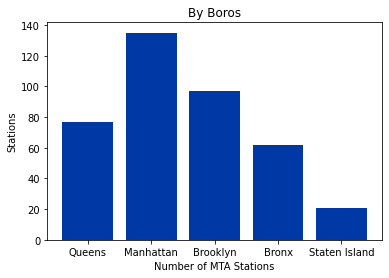

In [29]:
num_stations = [len(queen_station['Stop Name'].unique()), len(brooklyn_station['Stop Name'].unique()), len(manhattan_station['Stop Name'].unique()), len(bronx_station['Stop Name'].unique()), len(si_station['Stop Name'].unique())]
print('num_stations',num_stations, sum(num_stations))

boroughs = tuple(boros)
print('boroughs',boroughs)

y_pos = np.arange(len(boroughs))
print("y_pos", y_pos)

# Create bars and choose color
plt.bar(y_pos, num_stations, color = '#0039A6')

# Add title and axis names
plt.title('By Boros')
plt.xlabel('Number of MTA Stations')
plt.ylabel('Stations')

# Create names
plt.xticks(y_pos, boroughs)

# Show graphic
plt.show()

ada_stations [21, 35, 59, 15, 5] 135


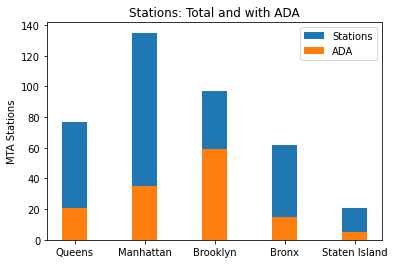

In [30]:
ada_stations = [len(queen_station[queen_station["ADA"] > 0 ]), len(brooklyn_station[brooklyn_station["ADA"] > 0 ]), len(manhattan_station[manhattan_station["ADA"] > 0 ]), len(bronx_station[bronx_station["ADA"] > 0 ]), len(si_station[si_station["ADA"] > 0 ])]
print('ada_stations',ada_stations, sum(ada_stations))

width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(y_pos, num_stations, width, label='Stations')
rects2 = ax.bar(y_pos, ada_stations, width, label='ADA')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MTA Stations')
ax.set_title('Stations: Total and with ADA')
ax.set_xticks(y_pos)
ax.set_xticklabels(boroughs)
ax.legend()


## Parse XML Data Feed

Example output from XML

```
<outage>
    <station>125 St</station>
    <borough>MN</borough>
    <trainno>1</trainno>
    <equipment>ES101</equipment>
    <equipmenttype>ES</equipmenttype>
    <serving>Street to Mezzanine</serving>
    <ADA>N</ADA>
    <outagedate>03/21/2021 9:42:00 AM</outagedate>
    <estimatedreturntoservice>03/27/2021 11:00:00 PM</estimatedreturntoservice>
    <reason>Planned Work</reason>
    <isupcomingoutage>N</isupcomingoutage>
    <ismaintenanceoutage>N</ismaintenanceoutage>
</outage>
```

In [31]:
# Elevator/Escalator Status Outage
outage_url = urlopen('http://web.mta.info/developers/data/nyct/nyct_ene.xml')
outage_xmldoc = parse(outage_url)
outage_xmldoc

In [32]:
# outage_feed_root = outage_xmldoc.getroot()
# outage_feed_root
outfeed = outage_xmldoc
findall_outage = outfeed.findall('./outage')

In [33]:
elemList = []
for elem in findall_outage:
    for i in elem.iter():
        if i != elem:
            elemList.append(i.tag)
    
station_outages_cols = list(set(elemList))
# station_outages_cols

In [34]:
outages_list = []
for row in findall_outage:
    colsObj = {}
    outages_list.append(colsObj)
    colsArr = []
    for cols in station_outages_cols:
        colsObj[cols] = row.find(cols).text
        colsArr.append(colsObj)
# outages_list

In [35]:
df_outage = pd.DataFrame(outages_list)
df_outage

,reason,serving,ismaintenanceoutage,equipment,outagedate,estimatedreturntoservice,equipmenttype,isupcomingoutage,station,trainno,borough,ADA
0,Repair,125 St & Lexington Ave (NE corner) to Mezzanin...,N,EL125,03/31/2021 8:34:00 PM,04/03/2021 11:00:00 PM,EL,N,125 St,4/5/6,MN,Y
1,Under Investigation,Street to Mezzanine,N,ES103,04/01/2021 7:24:00 PM,04/02/2021 4:00:00 AM,ES,N,125 St,1,MN,N
2,Planned Work,Street to Mezzanine,N,ES101,03/21/2021 9:42:00 AM,04/02/2021 11:00:00 PM,ES,N,125 St,1,MN,N
3,Repair,Street to Mezzanine all trains,N,ES258X,03/27/2021 7:37:00 PM,04/02/2021 11:00:00 PM,ES,N,14 St - Union Sq,L/N/Q/R/W,MN,N
4,Under Investigation,3rd Ave & 149 St (SW corner) to Platform for u...,N,EL129,04/01/2021 5:34:00 AM,04/02/2021 11:00:00 PM,EL,N,149 St - 3 Av,2/5,BX,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
61,Planned Work,Lower Mezzanine to Upper Mezzanine,N,ES315,03/19/2021 11:05:00 AM,06/01/2021 11:00:00 PM,ES,N,Smith - 9 Sts,F/G,BKN,N
62,Maintenance,Center Island Upper Platform to Mezzanine,N,ES435,04/02/2021 10:00:00 PM,04/03/2021 6:00:00 AM,ES,Y,Sutphin Blvd - Archer Av - JFK Airport,E/J/Z/LIRR,QNS,N
63,Repair,Street to Mezzanine to E/J/Z,N,ES433X,03/27/2021 6:40:00 PM,04/02/2021 11:00:00 PM,ES,N,Sutphin Blvd - Archer Av - JFK Airport,E/J/Z/LIRR,QNS,N
64,Repair,Sutphin Blvd & Archer Ave (SW intersection) to...,N,EL448X,03/28/2021 1:48:00 PM,04/01/2021 2:00:00 PM,EL,N,Sutphin Blvd - Archer Av - JFK Airport,E/J/Z/LIRR,QNS,Y


In [36]:
# Stack
df_outage.set_index(['equipmenttype', 'borough','station'])

reason  \
equipmenttype borough station                                                                   
EL            MN      125 St                                                           Repair   
ES            MN      125 St                                              Under Investigation   
                      125 St                                                     Planned Work   
                      14 St - Union Sq                                                 Repair   
EL            BX      149 St - 3 Av                                       Under Investigation   
...                                                                                       ...   
ES            BKN     Smith - 9 Sts                                              Planned Work   
              QNS     Sutphin Blvd - Archer Av - JFK Airport                      Maintenance   
                      Sutphin Blvd - Archer Av - JFK Airport                           Repair   
EL            QNS     Sutphin Blvd - Archer Av - JFK Airport                           Repair   
              MN      WTC Cortlandt St                        Station Is Under Rehabilitation   

                                                                                                        serving  \
equipmenttype borough station                                                                                     
EL            MN      125 St                                  125 St & Lexington Ave (NE corner) to Mezzanin...   
ES            MN      125 St                                                                Street to Mezzanine   
                      125 St                                                                Street to Mezzanine   
                      14 St - Union Sq                                           Street to Mezzanine all trains   
EL            BX      149 St - 3 Av                           3rd Ave & 149 St (SW corner) to Platform for u...   
...                                                                                                         ...   
ES            BKN     Smith - 9 Sts                                          Lower Mezzanine to Upper Mezzanine   
              QNS     Sutphin Blvd - Archer Av - JFK Airport          Center Island Upper Platform to Mezzanine   
                      Sutphin Blvd - Archer Av - JFK Airport                       Street to Mezzanine to E/J/Z   
EL            QNS     Sutphin Blvd - Archer Av - JFK Airport  Sutphin Blvd & Archer Ave (SW intersection) to...   
              MN      WTC Cortlandt St                                            Street to Southbound platform   

                                                             ismaintenanceoutage  \
equipmenttype borough station                                                      
EL            MN      125 St                                                   N   
ES            MN      125 St                                                   N   
                      125 St                                                   N   
                      14 St - Union Sq                                         N   
EL            BX      149 St - 3 Av                                            N   
...                                                                          ...   
ES            BKN     Smith - 9 Sts                                            N   
              QNS     Sutphin Blvd - Archer Av - JFK Airport                   N   
                      Sutphin Blvd - Archer Av - JFK Airport                   N   
EL            QNS     Sutphin Blvd - Archer Av - JFK Airport                   N   
              MN      WTC Cortlandt St                                         N   

                                                             equipment  \
equipmenttype borough station                                            
EL            MN      125 St                                     EL125   
ES            

In [37]:
df_outage_group = df_outage.groupby(['equipmenttype', 'borough'])["station"].unique()
df_outage_group

equipmenttype  borough
EL             BKN        [Atlantic Av-Barclays Ctr, Franklin Av, Jay St...
               BX                                           [149 St - 3 Av]
               MN         [125 St, 181 St, 190 St, 42 St - Bryant Park, ...
               QNS        [61 St - Woodside, Court Square - 23 St, Far R...
ES             BKN        [Atlantic Av-Barclays Ctr, Brighton Beach, Cou...
               BX                                         [Pelham Bay Park]
               MN         [125 St, 14 St - Union Sq, 34 St - Hudson Yard...
               QNS        [21 St - Queensbridge, Court Square, Flushing ...
Name: station, dtype: object

In [38]:
from collections import OrderedDict, defaultdict
df_outage_group.to_dict(OrderedDict)
for k,v in df_outage_group.to_dict(OrderedDict).items():
    print(k,v)

('EL', 'BKN') ['Atlantic Av-Barclays Ctr' 'Franklin Av' 'Jay St - MetroTech']
('EL', 'BX') ['149 St - 3 Av']
('EL', 'MN') ['125 St' '181 St' '190 St' '42 St - Bryant Park'
 '42 St - Port Authority Bus Terminal' '50 St' '96 St' 'Fulton St'
 'WTC Cortlandt St']
('EL', 'QNS') ['61 St - Woodside' 'Court Square - 23 St' 'Far Rockaway - Mott Av'
 'Howard Beach' 'Jackson Hts - Roosevelt Av' 'Jamaica - Van Wyck'
 'Queens Plaza' 'Sutphin Blvd - Archer Av - JFK Airport']
('ES', 'BKN') ['Atlantic Av-Barclays Ctr' 'Brighton Beach' 'Court St' 'Smith - 9 Sts']
('ES', 'BX') ['Pelham Bay Park']
('ES', 'MN') ['125 St' '14 St - Union Sq' '34 St - Hudson Yards'
 '42 St - Grand Central' '5 Av / 53 St' '51 St' '72 St / 2 Av'
 'Lexington Av / 53 St' 'Lexington Av / 63 St' 'Park Place']
('ES', 'QNS') ['21 St - Queensbridge' 'Court Square' 'Flushing Main St'
 'Jackson Hts - Roosevelt Av' 'Jamaica - Van Wyck'
 'Jamaica Center Parsons/Archer' 'Sutphin Blvd - Archer Av - JFK Airport']


In [39]:
df_outage_equip = pd.DataFrame(df_outage_group)
df_outage_equip

station
equipmenttype borough                                                   
EL            BKN      [Atlantic Av-Barclays Ctr, Franklin Av, Jay St...
              BX                                         [149 St - 3 Av]
              MN       [125 St, 181 St, 190 St, 42 St - Bryant Park, ...
              QNS      [61 St - Woodside, Court Square - 23 St, Far R...
ES            BKN      [Atlantic Av-Barclays Ctr, Brighton Beach, Cou...
              BX                                       [Pelham Bay Park]
              MN       [125 St, 14 St - Union Sq, 34 St - Hudson Yard...
              QNS      [21 St - Queensbridge, Court Square, Flushing ...

In [40]:
df_outage_equip

station
equipmenttype borough                                                   
EL            BKN      [Atlantic Av-Barclays Ctr, Franklin Av, Jay St...
              BX                                         [149 St - 3 Av]
              MN       [125 St, 181 St, 190 St, 42 St - Bryant Park, ...
              QNS      [61 St - Woodside, Court Square - 23 St, Far R...
ES            BKN      [Atlantic Av-Barclays Ctr, Brighton Beach, Cou...
              BX                                       [Pelham Bay Park]
              MN       [125 St, 14 St - Union Sq, 34 St - Hudson Yard...
              QNS      [21 St - Queensbridge, Court Square, Flushing ...

In [41]:
df_outage.sort_values(by=['equipmenttype', 'borough'], ascending=False)

,reason,serving,ismaintenanceoutage,equipment,outagedate,estimatedreturntoservice,equipmenttype,isupcomingoutage,station,trainno,borough,ADA
13,Under Investigation,Northbound Platform to Mezzanine,N,ES426,04/01/2021 7:47:00 PM,04/02/2021 4:00:00 AM,ES,N,21 St - Queensbridge,F,QNS,N
14,Under Investigation,Southbound Platform to Mezzanine,N,ES423,04/01/2021 4:37:00 PM,04/02/2021 1:00:00 AM,ES,N,21 St - Queensbridge,F,QNS,N
34,Repair,Street to Mezzanine passageway to E/G/M,N,ES265X,04/01/2021 3:58:00 PM,04/03/2021 11:00:00 PM,ES,N,Court Square,7,QNS,N
38,Capital Replacement,Street to Mezzanine,N,ES455,02/19/2021 10:07:00 PM,07/03/2021 11:00:00 PM,ES,N,Flushing Main St,7,QNS,N
39,Capital Replacement,Street to Mezzanine,N,ES456,02/19/2021 10:07:00 PM,07/03/2021 11:00:00 PM,ES,N,Flushing Main St,7,QNS,N
...,...,...,...,...,...,...,...,...,...,...,...,...
30,Maintenance,Mezzanine to D/N/R Coney Island and Bay Ridge ...,N,EL302,04/01/2021 10:30:00 PM,04/02/2021 6:00:00 AM,EL,Y,Atlantic Av-Barclays Ctr,2/3/4/5/B/D/N/Q/R,BKN,Y
31,Elevator Rehabilitation,Plaza entrance in front of Barclays Center to ...,N,EL700X,03/10/2021 10:30:00 AM,04/16/2021 4:00:00 PM,EL,N,Atlantic Av-Barclays Ctr,2/3/4/5/B/D/N/Q/R/LIRR,BKN,Y
40,Capital Replacement,Fulton St & Franklin Ave (NW corner) to footbr...,N,EL340,07/27/2020 10:00:00 AM,04/27/2021 11:00:00 PM,EL,N,Franklin Av,C/S,BKN,Y
41,Capital Replacement,Fulton St & Franklin Ave (SW corner) to transf...,N,EL339,07/27/2020 9:40:00 AM,04/27/2021 11:00:00 PM,EL,N,Franklin Av,C/S,BKN,Y
